In [94]:
# Importing the required libraries
time_window=10
import math
import pandas as pd
import numpy as np
from math import sqrt
from numpy import array, concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [95]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.flush_and_unmount()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Gather the Company Stock Price Dataset and Covid Dataset and combining it into a single**

In [96]:
# Reading Confirmed covid cases in the US file in csv and converting it into dataframe
covid_dataset = read_csv('/content/gdrive/MyDrive/us_confirmed_cases.csv', usecols = ['Country/Region','US'], parse_dates=["Country/Region"])
covid_dataset = covid_dataset[1:]
covid_dataset.columns = ['Date', 'US']
covid_dataset['Date'] = pd.to_datetime(covid_dataset.Date)
covid_dataset['Date'] = covid_dataset['Date'].dt.strftime('%m/%d/%Y')
covid_dataset.head(5)

,Date,US
1,01/23/2020,0.0
2,01/24/2020,1.0
3,01/25/2020,0.0
4,01/26/2020,3.0
5,01/27/2020,0.0


In [97]:
#Reading Amazon stock prices data file in csv and converting it into dataframe
file_name="AMZN.csv"
# file_name="DAL.csv"
# file_name="NFLX.csv"
# file_name="UAL.csv"
stock_dataset = read_csv('/content/gdrive/MyDrive/'+file_name, usecols=['Date', 'High', 'Low'])
stock_dataset['Date'] = pd.to_datetime(stock_dataset.Date)
stock_dataset['Date'] = stock_dataset['Date'].dt.strftime('%m/%d/%Y')
stock_dataset.head(5)

,Date,High,Low
0,05/11/2016,719.000000,701.650024
1,05/12/2016,722.450012,711.510010
2,05/13/2016,719.250000,706.510010
3,05/16/2016,713.250000,700.280029
4,05/17/2016,714.469971,693.909973


In [98]:
# Merging the covid_dataset and stock_dataset to get the dataset needed to train the LSTM model
merged_dataset = pd.merge(left=covid_dataset, right=stock_dataset, how='left', left_on='Date', right_on='Date')

# Taking the Average of low and high values from the merged_dataset
high_prices = merged_dataset.loc[:,'High'].to_numpy()
low_prices = merged_dataset.loc[:,'Low'].to_numpy()
merged_dataset['Average'] = (high_prices+low_prices)/2.0
merged_dataset=merged_dataset.drop(['High', 'Low'], axis=1)
merged_dataset.head(20)

,Date,US,Average
0,01/23/2020,0.0,1881.369995
1,01/24/2020,1.0,1871.214965
2,01/25/2020,0.0,NaN
3,01/26/2020,3.0,NaN
4,01/27/2020,0.0,1828.169983
5,01/28/2020,0.0,1844.065002
6,01/29/2020,1.0,1864.885010
7,01/30/2020,0.0,1861.739990
8,01/31/2020,2.0,2028.994995
9,02/01/2020,0.0,NaN


In [99]:
# Filling the NaN values with the previous days average value 
merged_dataset['Average'].fillna(method='ffill', inplace=True)

# Making the date column as index of the merged_dataset
merged_dataset.set_index('Date', inplace=True)

In [100]:
# Re arranging the columns and saving it to a csv file
merged_dataset=merged_dataset.reindex(columns=['Average', 'US'])
merged_dataset.to_csv('final.csv')
avg_dataset=merged_dataset["Average"]
merged_dataset

,Average,US
Date,,
01/23/2020,1881.369995,0.0
01/24/2020,1871.214965,1.0
01/25/2020,1871.214965,0.0
01/26/2020,1871.214965,3.0
01/27/2020,1828.169983,0.0
...,...,...
05/04/2021,3320.054931,40733.0
05/05/2021,3309.530029,44510.0
05/06/2021,3280.799926,47366.0


**Prepare data for LSTM model**

In [101]:
# converting series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('final.csv', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, time_window, 1)
# drop columns we don't want to predict

covid_cases=reframed.iloc[:,-1]
reframed.drop(reframed.columns[-1], axis=1, inplace=True)
reframed.head(10)

,var1(t-10),var2(t-10),var1(t-9),var2(t-9),var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
10,0.103261,0.000000,0.097702,0.000003,0.097702,0.000000,0.097702,0.000010,0.074138,0.000000,0.082839,0.000000,0.094237,0.000003,0.092515,0.000000,0.184075,0.000007,0.184075,0.000000,0.184075
11,0.097702,0.000003,0.097702,0.000000,0.097702,0.000010,0.074138,0.000000,0.082839,0.000000,0.094237,0.000003,0.092515,0.000000,0.184075,0.000007,0.184075,0.000000,0.184075,0.000000,0.181546
12,0.097702,0.000000,0.097702,0.000010,0.074138,0.000000,0.082839,0.000000,0.094237,0.000003,0.092515,0.000000,0.184075,0.000007,0.184075,0.000000,0.184075,0.000000,0.181546,0.000010,0.188777
13,0.097702,0.000010,0.074138,0.000000,0.082839,0.000000,0.094237,0.000003,0.092515,0.000000,0.184075,0.000007,0.184075,0.000000,0.184075,0.000000,0.181546,0.000010,0.188777,0.000000,0.196400
14,0.074138,0.000000,0.082839,0.000000,0.094237,0.000003,0.092515,0.000000,0.184075,0.000007,0.184075,0.000000,0.184075,0.000000,0.181546,0.000010,0.188777,0.000000,0.196400,0.000000,0.190400
15,0.082839,0.000000,0.094237,0.000003,0.092515,0.000000,0.184075,0.000007,0.184075,0.000000,0.184075,0.000000,0.181546,0.000010,0.188777,0.000000,0.196400,0.000000,0.190400,0.000003,0.205600
16,0.094237,0.000003,0.092515,0.000000,0.184075,0.000007,0.184075,0.000000,0.184075,0.000000,0.181546,0.000010,0.188777,0.000000,0.196400,0.000000,0.190400,0.000003,0.205600,0.000000,0.205600
17,0.092515,0.000000,0.184075,0.000007,0.184075,0.000000,0.184075,0.000000,0.181546,0.000010,0.188777,0.000000,0.196400,0.000000,0.190400,0.000003,0.205600,0.000000,0.205600,0.000000,0.205600
18,0.184075,0.000007,0.184075,0.000000,0.184075,0.000000,0.181546,0.000010,0.188777,0.000000,0.196400,0.000000,0.190400,0.000003,0.205600,0.000000,0.205600,0.000000,0.205600,0.000000,0.228572
19,0.184075,0.000000,0.184075,0.000000,0.181546,0.000010,0.188777,0.000000,0.196400,0.000000,0.190400,0.000003,0.205600,0.000000,0.205600,0.000000,0.205600,0.000000,0.228572,0.000000,0.256324


**Split the dataset into train and test sets**

In [102]:
# Considering 70% of the data as train set and the remaining as test set
values = reframed.values
n_train_hours = math.floor(0.7 * values.shape[0])
train = values[:n_train_hours, :]
# print(train.shape)
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
last_five_days=train_X[-1:,:]
# print(last_five_days.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
days_prediction=test_y.shape[0]
# days_prediction

(323, 1, 20) (323,) (139, 1, 20) (139,)


**Designing the LSTM Model**

In [103]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(train_X,train_y,validation_data=(test_X, test_y),epochs=100,batch_size=25,verbose=2, shuffle=False)

Epoch 1/100
13/13 - 5s - loss: 0.3563 - val_loss: 0.5778
Epoch 2/100
13/13 - 0s - loss: 0.2495 - val_loss: 0.3390
Epoch 3/100
13/13 - 0s - loss: 0.0692 - val_loss: 0.0135
Epoch 4/100
13/13 - 0s - loss: 0.0246 - val_loss: 0.0187
Epoch 5/100
13/13 - 0s - loss: 0.0226 - val_loss: 0.0193
Epoch 6/100
13/13 - 0s - loss: 0.0099 - val_loss: 0.0086
Epoch 7/100
13/13 - 0s - loss: 0.0092 - val_loss: 0.0068
Epoch 8/100
13/13 - 0s - loss: 0.0094 - val_loss: 0.0052
Epoch 9/100
13/13 - 0s - loss: 0.0076 - val_loss: 0.0055
Epoch 10/100
13/13 - 0s - loss: 0.0072 - val_loss: 0.0044
Epoch 11/100
13/13 - 0s - loss: 0.0065 - val_loss: 0.0040
Epoch 12/100
13/13 - 0s - loss: 0.0059 - val_loss: 0.0035
Epoch 13/100
13/13 - 0s - loss: 0.0054 - val_loss: 0.0031
Epoch 14/100
13/13 - 0s - loss: 0.0049 - val_loss: 0.0027
Epoch 15/100
13/13 - 0s - loss: 0.0045 - val_loss: 0.0024
Epoch 16/100
13/13 - 0s - loss: 0.0041 - val_loss: 0.0022
Epoch 17/100
13/13 - 0s - loss: 0.0039 - val_loss: 0.0020
Epoch 18/100
13/13 - 0s

Text(0.5, 1.0, 'Train vs test data - AMZN.csv')

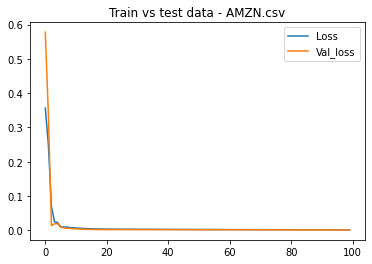

In [104]:
# plot history
pyplot.plot(history.history['loss'], label='Loss')
pyplot.plot(history.history['val_loss'], label='Val_loss')
pyplot.legend()
plt.title('Train vs test data - '+ file_name)

In [105]:
# Making predictions and calculate the RMSE value
print(test_X.shape)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

# calculate Root Mean Square Error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(139, 1, 20)
Test RMSE: 39.331


**Plotting graph between train data, test data and predicted data**

In [106]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
inv_x=scaler.inverse_transform(train_X[:,-2:])
day_new=np.arange(1,train_X.shape[0]+1)
day_pred=np.arange(train_X.shape[0]+1,train_X.shape[0]+1+inv_y.shape[0])

Text(0.5, 1.0, 'Stock price prediction - AMZN.csv')

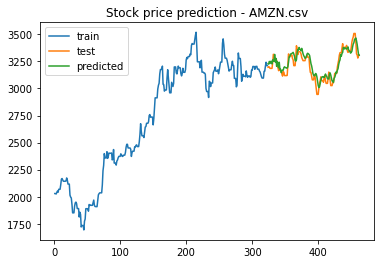

In [107]:
plt.plot(day_new,inv_x[:,0], label='train')
plt.plot(day_pred,inv_y[:,0], label='test')
plt.plot(day_pred,inv_yhat[:,0], label='predicted')
plt.legend()
plt.title('Stock price prediction - '+file_name)

**Prediciting the stock prices for the next days based on the existing data**

In [108]:
# preparing data for prediction
x_input=last_five_days
x_input_1=x_input.reshape(1,-1)
print(x_input_1.shape)
x_input_2=x_input.reshape(1,-1)
temp_input_1=list(x_input_1)
temp_input_1=x_input_1[0].tolist()
temp_input_2=list(x_input_1)
temp_input_2=x_input_1[0].tolist()


(1, 20)


In [109]:
covid_cases=covid_cases[-days_prediction:].values
covid_cases=covid_cases.reshape(1,-1)
covid_cases=list(covid_cases)
covid_cases=covid_cases[0].tolist()
covid_cases = [[i] for i in covid_cases]

In [110]:
# prediction for next days
days=days_prediction
lst_output=[]
n_steps=time_window*2
i=0
while(i<days):
    
    if(len(temp_input_1)>n_steps):
      x_input_1=np.array(temp_input_1[2:])
      x_input_1=x_input_1.reshape(1,-1)
      x_input_1 = x_input_1.reshape((1, 1, n_steps))
      yhat = model.predict(x_input_1, verbose=0)
      temp_input_1.extend(yhat[0].tolist())
      temp_input_1.extend(covid_cases[i])
      temp_input_1=temp_input_1[2:]
      lst_output.extend(yhat.tolist())
      i=i+1
    else:
      x_input_1 = x_input_1.reshape((1, 1,n_steps))
      yhat = model.predict(x_input_1, verbose=0)
      temp_input_1.extend(yhat[0].tolist())
      temp_input_1.extend(covid_cases[i])
      lst_output.extend(yhat.tolist())
      i=i+1
    

print(lst_output)

[[0.834968090057373], [0.8403168320655823], [0.8430874943733215], [0.8547711372375488], [0.856318473815918], [0.8824562430381775], [0.8743226528167725], [0.9066758751869202], [0.9002565145492554], [0.8843172192573547], [0.9064608216285706], [0.8718059062957764], [0.8834670186042786], [0.8414062261581421], [0.8575191497802734], [0.8529036045074463], [0.8315210938453674], [0.8604698777198792], [0.833460807800293], [0.8357454538345337], [0.8153895139694214], [0.8205018043518066], [0.825934648513794], [0.8325369358062744], [0.843310534954071], [0.8511197566986084], [0.8577427864074707], [0.8633037805557251], [0.8670076131820679], [0.8756235837936401], [0.8895334005355835], [0.9014781713485718], [0.9111826419830322], [0.9052475690841675], [0.9117981195449829], [0.9063281416893005], [0.9079391360282898], [0.9121223092079163], [0.9187041521072388], [0.9166331887245178], [0.9209453463554382], [0.9127292633056641], [0.9134328365325928], [0.9101189970970154], [0.9196105599403381], [0.92457288503

Test RMSE: 157.250


Text(0.5, 1.0, 'AMZN.csv stock price data along with covid cases')

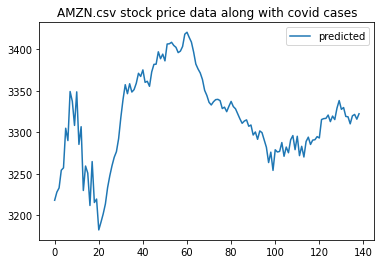

In [111]:
# Plotting graph to visualize the next days prediction
output = concatenate((lst_output, covid_cases[-days_prediction:]), axis=1)
output = scaler.inverse_transform(output)
plt.plot(output[:,0],label='predicted')

# plt.plot(inv_y[:,0],label='actual')
rmse = sqrt(mean_squared_error(output[:,0], inv_y[:,0]))
print('Test RMSE: %.3f' % rmse)
plt.legend()
plt.title(file_name + ' stock price data along with covid cases')

**Prediciting the stock prices for the next days based on the condition that there is no covid cases in the future**

In [112]:
# creating a new series with zero values for 
zero_covid = [0] * days_prediction
zero_covid_cases=pd.Series(zero_covid).astype(np.float32) 
no_covid_cases=zero_covid_cases
no_covid_cases=no_covid_cases.values
no_covid_cases=no_covid_cases.reshape(1,-1)
no_covid_cases=list(no_covid_cases)
no_covid_cases=no_covid_cases[0].tolist()
print(no_covid_cases)
no_covid_cases = [[i] for i in no_covid_cases]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [113]:
# prediction for next days
from numpy import array
days=days_prediction
lst_output_1=[]
n_steps=time_window*2
i=0
while(i<days):
    
    if(len(temp_input_2)>n_steps):
      x_input_2=np.array(temp_input_2[2:])
      x_input_2=x_input_2.reshape(1,-1)
      x_input_2 = x_input_2.reshape((1, 1, n_steps))
      yhat = model.predict(x_input_2, verbose=0)
      temp_input_2.extend(yhat[0].tolist())
      temp_input_2.extend(no_covid_cases[i])
      temp_input_2=temp_input_2[2:]
      lst_output_1.extend(yhat.tolist())
      i=i+1
    else:
      x_input_2 = x_input_2.reshape((1, 1,n_steps))
      yhat = model.predict(x_input_2, verbose=0)
      temp_input_2.extend(yhat[0].tolist())
      temp_input_2.extend(no_covid_cases[i])
      lst_output_1.extend(yhat.tolist())
      i=i+1
    

print(lst_output_1)

[[0.834968090057373], [0.8613795042037964], [0.882086455821991], [0.9463345408439636], [1.011951208114624], [1.0459766387939453], [1.1004847288131714], [1.1064924001693726], [1.1141749620437622], [1.0861883163452148], [1.0609887838363647], [1.0496275424957275], [1.0328164100646973], [1.0124925374984741], [0.9911971092224121], [0.9724005460739136], [0.9542580246925354], [0.9368071556091309], [0.9200424551963806], [0.9067682027816772], [0.894560694694519], [0.8825315833091736], [0.8715985417366028], [0.8618526458740234], [0.8531191349029541], [0.8448585271835327], [0.8371320962905884], [0.8301001787185669], [0.8236081600189209], [0.8173794150352478], [0.8114752173423767], [0.8059397339820862], [0.8007019758224487], [0.795680046081543], [0.790844202041626], [0.7862195372581482], [0.7817811965942383], [0.7774847745895386], [0.7733184099197388], [0.7692862749099731], [0.7653761506080627], [0.7615688443183899], [0.7578545808792114], [0.7542305588722229], [0.7506923675537109], [0.747228622436

Test RMSE: 428.809


Text(0.5, 1.0, 'AMZN.csv stock price data without covid cases')

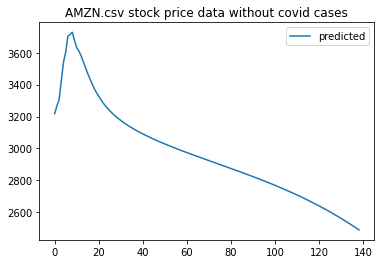

In [114]:
# Plotting graph to visualize the next days prediction
output_1 = concatenate((lst_output_1, no_covid_cases), axis=1)
output_1 = scaler.inverse_transform(output_1)
plt.plot(output_1[:,0],label='predicted')
rmse = sqrt(mean_squared_error(output_1[:,0], inv_y[:,0]))
print('Test RMSE: %.3f' % rmse)

# plt.plot(inv_y[:,0],label='actual')
plt.legend()
plt.title( file_name + ' stock price data without covid cases')

Text(0.5, 1.0, 'AMZN.csv')

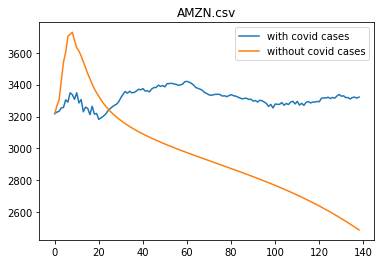

In [115]:
  plt.plot(output[:,0],label='with covid cases')
plt.plot(output_1[:,0],label='without covid cases')
plt.legend()

plt.title(file_name)
